# CMM536 – Advanced Data Science Coursework

## Classification of Medical X-Ray Images Using Computer Vision.

### Student Name: Oghenerie Perkins Offi

### Student ID: 2114921

# Introduction

The use of data science has evolved tremendously in recent times, with its application now cutting across almost all sectors. One of these is the Medical sector. Millions of medical images are now being analyzed using modern data science, thanks to recent advances in computer vision and machine learning.

The aim of this project is to design a comparative experimental validation framework to test 
different computer vision and machine learning algorithms which will help in the classification of
medical x-ray images from three different body sections; Knee, Hand and Chest. 

# Data Collection

The medical x-ray images were collected from three sources; [Gornale & Patravali (2020)](https://data.mendeley.com/datasets/t9ndx37v5h/1 "Digital Knee X-ray Images"), [Budnychuk (2021)](https://www.kaggle.com/antonbudnychuk/hand-xray "Hand X-ray Images") and [Shams, Elzeki & Abd Elfattah (2020)](https://data.mendeley.com/datasets/fvk7h5dg2p/1 "Chest X-ray Images"). The x-ray images collected were randomly selected and are a combination of both positive and negative cases; The knee x-ray images are a combination of fractured and normal knees, the hand x-ray images are a combination of fractured and normal hands, and the chest x-ray images are a combination of COVID-19, normal and pneumonia-affected chests.The dataset is an imbalanced dataset with a total of 2885 medical x-ray images.

The distribution of the collected dataset are:

1. 1456 Knee X-ray images. The original dataset consists of 1650 digital X-ray images of knee joint which were collected from well reputed hospitals and diagnostic centres. It was made up of 5 categories; Normal, Doubtful, Mild, Moderate, and Severe. The images selected for this project were selected randomly (Random mouse drag) across the 5 categories and came to a total of 1456.

2. 826 Hand X-ray images. The original dataset consists of 41,700 X-ray images of different body parts. It was made up of three categories; test, train and validation, with each category grouped into hands and others (X-ray from other body parts). The 826 images selected for this project were selected randomly from the hands group in the test category which consisted of 1645 images.

3. 603 Chest X-ray images. This consists of all the images in the original dataset which was made up of 603 chest x-ray images from three categories; COVID-19 cases, normal and pneumonia.

The compiled dataset can be found [here](https://drive.google.com/drive/folders/1--4x4hpWKpHHBAzfnsFJluh2sKKREgpk?usp=sharing "Xray_Repo").

### Sample Images

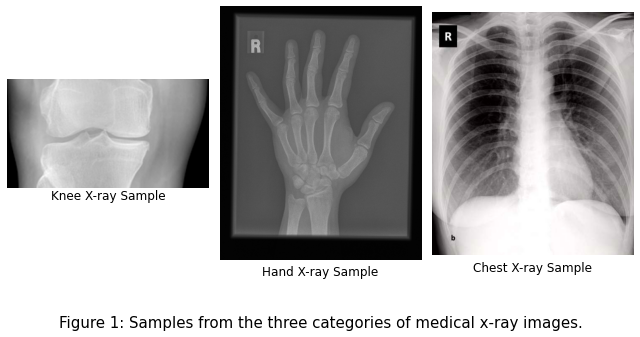

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

Knee_Sample = cv.imread('Xray_Repo/Knee/knee 01.png')
Hand_Sample = cv.imread('Xray_Repo/Hand/hand 01.png')
Chest_Sample = cv.imread('Xray_Repo/Chest/Chest 02.png')

f, ax = plt.subplots(1, 3, figsize = (9,5))

ax[0].imshow(Knee_Sample)
ax[1].imshow(Hand_Sample)
ax[2].imshow(Chest_Sample)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

ax[0].set_title('Knee X-ray Sample', y = -0.16)
ax[1].set_title('Hand X-ray Sample', y = -0.08)
ax[2].set_title('Chest X-ray Sample', y = -0.09)

title = 'Figure 1: Samples from the three categories of medical x-ray images.'

plt.tight_layout()
f.suptitle(title, fontsize = 15, y = -0.004)
plt.show()

Figure 1 above shows sample images from the three categories of x-ray images in the dataset.

### Loading all relevant libraries

In [2]:
#GENERAL
import cv2 as cv
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import numpy as np
import pandas as pd
from timeit import default_timer as timer

### Data Random Oversampling
from imblearn.over_sampling import RandomOverSampler

### Image Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### BINARISATION AND HOG
from skimage import filters, restoration, feature

## Experiment
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics        
from numpy import average

## CNN
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

# Data Loading and Preprocessing
The X-ray images which were stored within three folders based on their respective classes, were loaded in a loop. They were resized to a uniform size of 100x100 to ensure consistency across the dataset. They were then stored in a repo called 'imagesdata'. Another repo called 'target' was created where the class labels were stored.

## Creating image repositories

In order to evaluate the impact of preprocessing techniques on model performance, three additional repos were created using different techniques. They are:

- AugImages: Repo of augmented imagesdata repo using keras image data generator.
- hogrepo: Repo of extracted features using Histogram of Oriented Gradients (HOG) from the original flattened repo.
- hogrepo_ros: Repo of augmented HOG repo using random oversampling (ROS).

The 'target' repo class labels were one-hot-encoded to integer labels to enable use in Convolutional Neural Network (CNN) and saved in 'targetnum'. The targetnum desciption for use in CNN are;

- Chest = 0
- Hand = 1
- Knee = 2

In [3]:
start = timer()

resize_width = 100
resize_height = 100

path = 'Xray_Repo'

imagesdata = [] # List to append the images as 2D numpy arrays.
target = [] # List to append the target labels.
originalrepo = [] # Create a repo for flattened pixels.
hogrepo = [] # Repo for feature extracted pixels.

for root, dirs, files in os.walk(path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv.imread(root+'/'+file, 0)
                img = cv.resize(img, (resize_width, resize_height)) 
                imagesdata.append(img)
                # Append the flattened image to originalrepo
                originalrepo.append(img.flatten())
                
##################### CREATING A REPO USING THE HISTOGRAM OF GRADIENTS FEATURE EXTRACTION METHOD ##########################          
                hg, hog_img = feature.hog(img, orientations=18, pixels_per_cell=(10, 10), cells_per_block=(1, 1), visualize=True)
                hogrepo.append(hg) #append features to hog repo
        
                # Append the folder where the image is to the target list
                target.append(root.replace(path,'').replace('\\','').replace('/',''))
                
            except Exception as e:
                print("Invalid file "+file+" skipped.")
                
######### SHOWING REPOS BASED ON CLASS ##########
labels = sorted(list(set(target)))
values = []
for i in labels:
    values.append(target.count(i))  

######### CONVERTING REPO LISTS TO NUMPY ARRAYS ############ 
imagesdata = np.array(imagesdata)
originalrepo = np.array(originalrepo)
hogrepo = np.array(hogrepo)


########## ONE-HOT-ENCODING TARGET LABELS TO INTEGER LABELS ###########
targetnum = target.copy()
for index, items in enumerate(targetnum):
    if items == 'Chest':
        targetnum[index] = 0
    elif items == 'Hand':
        targetnum[index] = 1
    else :
        targetnum[index] = 2
targetnum = np.array(targetnum)    

############################# PRINTING REPO SAMPLES #####################################
print('Sample of the original repo:')
print(originalrepo)
print('The shape of the original repo is:' + str(originalrepo.shape))
print('')

print('Sample of the HOG repo:')
print(hogrepo)
print('The shape of the HOG repo is:' + str(hogrepo.shape))
print('')

print('Sample of class labels: ')
print(np.array(target))
print('')

print('Sample of integer class labels where Chest = 0, Hand = 1 and Knee = 2 ')
print(targetnum)
print('')

####################### SAVING THE DATASETS AS CSV FILES ############################

print('\nSaving datasets as .csv files...')
        
with open('original.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, pix in enumerate(originalrepo):
        row = np.concatenate((pix,[target[i]]))
        filewriter.writerow(row)

with open('hog.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, h in enumerate(hogrepo):
        row = np.concatenate((h,[target[i]]))
        filewriter.writerow(row)

print('\nData saved into .csv files!')  

end = timer()
print('Elapsed time:' + str(round(((end - start)/60), 2)) + ' mins')

Sample of the original repo:
[[112  98 105 ... 225 221 213]
 [ 51  50  50 ... 157 155 149]
 [ 51  62  61 ... 104  79  92]
 ...
 [  3   0  15 ...  57  32  29]
 [ 62  66  66 ...  43  40  20]
 [ 74  81  82 ...  94  70  79]]
The shape of the original repo is:(2885, 10000)

Sample of the HOG repo:
[[0.43719283 0.00359646 0.0127154  ... 0.56068402 0.4138995  0.        ]
 [0.30578234 0.30578234 0.30578234 ... 0.37628753 0.37628753 0.37628753]
 [0.33169555 0.24798416 0.06925735 ... 0.08125914 0.31208245 0.31208245]
 ...
 [0.5322706  0.26534344 0.02140271 ... 0.06119132 0.12027394 0.22869482]
 [0.48915004 0.48915004 0.12489149 ... 0.47857856 0.47857856 0.47857856]
 [0.49510477 0.49510477 0.20729198 ... 0.38579444 0.38579444 0.28510784]]
The shape of the HOG repo is:(2885, 1800)

Sample of class labels: 
['Chest' 'Chest' 'Chest' ... 'Knee' 'Knee' 'Knee']

Sample of integer class labels where Chest = 0, Hand = 1 and Knee = 2 
[0 0 0 ... 2 2 2]


Saving datasets as .csv files...

Data saved into .

### Plotting the distribution of classes in the dataset

Class  No of Samples
Chest            603
 Hand            826
 Knee           1456


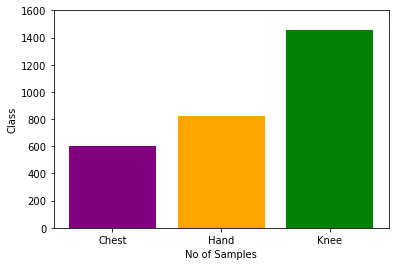

The total number of images in each repo is:2885



In [4]:
####### CREATING FUNCTION TO PRINT AND PLOT CLASS DISTRIBUTION #######

def barplot(labels, values):
    
    ''' barplot to show distribution of classes
    input:
    labels: class names (target)
    values: no of samples per target
        
    '''
    bar_data = pd.DataFrame({"Class":labels, "No of Samples":values})
    
    colors = ['purple','orange','green','yellow','blue','red']
    plt.bar(('Class'), 'No of Samples', data=bar_data, color=colors)
    plt.ylabel('Class')
    plt.xlabel('No of Samples')
    #plt.xticks(rotation=30, horizontalalignment='right')
    yint = []
    locs, labels = plt.yticks()
    for each in locs:
        yint.append(int(each))
        plt.yticks(yint)
    print(bar_data.to_string(index=False))
    return plt.show()

######### PRINTING AND PLOTTING BARPLOT TO SHOW CLASS DISTRIBUTION ############
barplot(labels,values)

print('The total number of images in each repo is:' + str(len(target))) 
print('')

# Validation

### Stratified Data Split
To avoid overfitting of the experiments, a stratified data split was applied to the data so that 70% of the dataset was used for training and the remaining 30% for testing.

The training dataset has 2019 samples.
The test dataset has 866 samples.

Class distribution for the training set:
Class  No of Samples
Chest            422
 Hand            578
 Knee           1019


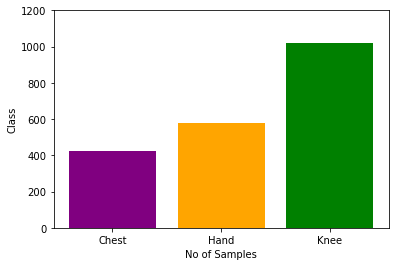


Class distribution for the test set:
Class  No of Samples
Chest            181
 Hand            248
 Knee            437


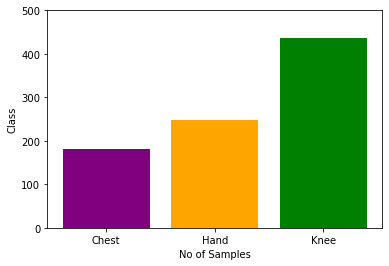

In [5]:
####################################SPLITTING THE DATASET INTO TRAIN AND TEST##########################################
imagesdata_train, imagesdata_test, targetimagesdata_train, targetimagesdata_test = train_test_split(imagesdata, 
                                                                          target, train_size=0.7, test_size=0.3, 
                                                                          random_state=42, stratify=target)

original_train, original_test, targetoriginal_train, targetoriginal_test = train_test_split(originalrepo, 
                                                                          target, train_size=0.7, test_size=0.3, 
                                                                          random_state=42, stratify=target)

hog_train, hog_test, targethog_train, targethog_test = train_test_split(hogrepo, 
                                                                          target, train_size=0.7, test_size=0.3, 
                                                                          random_state=42, stratify=target)

print('The training dataset has' + ' ' + str(original_train.shape[0]) + ' ' + 'samples.')
print('The test dataset has' + ' ' + str(original_test.shape[0]) + ' ' + 'samples.')

################ PRINTING AND PLOTTING BARPLOT TO SHOW CLASS DISTRIBUTION OF SPLITTED DATASET ######################
labelsoriginal_train = sorted(list(set(targetoriginal_train)))
valuesoriginal_train = []
for i in labelsoriginal_train:
    valuesoriginal_train.append(targetoriginal_train.count(i))

labelsoriginal_test = sorted(list(set(targetoriginal_test)))
valuesoriginal_test = []
for i in labelsoriginal_test:
    valuesoriginal_test.append(targetoriginal_test.count(i))
    
print('')

print('Class distribution for the training set:')

barplot(labelsoriginal_train, valuesoriginal_train)

print('')

print('Class distribution for the test set:')

barplot(labelsoriginal_test, valuesoriginal_test)

# Experiment A
For this experiment, a CNN was trained using the training dataset of the unaltered dataset (imagesdata_train) and used to classify the test set (imagesdata_test). Precision, Recall and F1-score metrics were obtained for the experiment.

### Convolutional Neural Network

In [6]:
#Convverting the test and train sets into numpy arrays.
imagesdata_train = np.array(imagesdata_train)
imagesdata_test = np.array(imagesdata_test)
targetimagesdata_train = np.array(targetimagesdata_train)
targetimagesdata_test = np.array(targetimagesdata_test)

In [7]:
#Checking the shape of the data obtained.
print(imagesdata_train.shape, targetimagesdata_train.shape, imagesdata_test.shape, targetimagesdata_test.shape)

(2019, 100, 100) (2019,) (866, 100, 100) (866,)


In [8]:
#One-Hot-Encoding labels for use in CNN.
targetnum1 = targetimagesdata_train.copy()
for index, items in enumerate(targetnum1):
    if items == 'Chest':
        targetnum1[index] = 0
    elif items == 'Hand':
        targetnum1[index] = 1
    else :
        targetnum1[index] = 2

print(targetnum1)

targetnum2 = targetimagesdata_test.copy()
for index, items in enumerate(targetnum2):
    if items == 'Chest':
        targetnum2[index] = 0
    elif items == 'Hand':
        targetnum2[index] = 1
    else :
        targetnum2[index] = 2

['2' '2' '0' ... '1' '1' '2']


In [9]:
###Preprocessing input data.

#Reshaping into four dimensions.
imagesdata_train_reshape = imagesdata_train.reshape(imagesdata_train.shape[0], 100, 100, 1)
imagesdata_test_reshape = imagesdata_test.reshape(imagesdata_test.shape[0], 100, 100, 1)

#Converting to float 32.
imagesdata_train_reshape = imagesdata_train_reshape.astype('float32')
imagesdata_test_reshape = imagesdata_test_reshape.astype('float32')

#Normalising.
imagesdata_train_reshape /= 255 
imagesdata_test_reshape /= 255

#Preprocessing class labels
targetimagesdata_train_categorical = np_utils.to_categorical(targetnum1, 3)
targetimagesdata_test_categorical = np_utils.to_categorical(targetnum2, 3)

In [10]:
start = timer()
os.environ['KERAS_BACKEND'] = 'tensorflow'

#Setting random seed for reproducibility.
np.random.seed(59)

#Defining the model architecture.
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#Compiling the model.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model on the training data.
model.fit(imagesdata_train_reshape, targetimagesdata_train_categorical, batch_size=32, epochs=5, verbose=1)

end = timer()
print('Elapsed time:' + str(round(((end - start)/60), 2)) + ' mins')

Epoch 1/5
64/64 [==============================] - 24s 368ms/step - loss: 0.5175 - accuracy: 0.8460
Epoch 2/5
64/64 [==============================] - 25s 397ms/step - loss: 0.0779 - accuracy: 0.9742
Epoch 3/5
64/64 [==============================] - 24s 378ms/step - loss: 0.0490 - accuracy: 0.9876
Epoch 4/5
64/64 [==============================] - 25s 383ms/step - loss: 0.0307 - accuracy: 0.9906
Epoch 5/5
64/64 [==============================] - 24s 370ms/step - loss: 0.0267 - accuracy: 0.9926
Elapsed time:2.04 mins


In [11]:
#Viewing model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 128)               9437312   
                                                        

In [12]:
#Evaluating model on test data.
loss, accuracy = model.evaluate(imagesdata_test_reshape, targetimagesdata_test_categorical, verbose=0)
print('Loss: ', loss, 'n\Acc: ', accuracy)

Loss:  0.03106566146016121 n\Acc:  0.9930716156959534


In [13]:
#Making predictions.
predict_imagesdata1=model.predict(imagesdata_test_reshape)
predict_imagesdata_classes1= np.argmax(predict_imagesdata1,axis=1)
targetimagesdata_test_categorical1 = np.argmax(targetimagesdata_test_categorical,axis=1)

In [14]:
#Printing Classification Report.
print(classification_report(targetimagesdata_test_categorical1, predict_imagesdata_classes1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       181
           1       0.98      1.00      0.99       248
           2       1.00      1.00      1.00       437

    accuracy                           0.99       866
   macro avg       0.99      0.99      0.99       866
weighted avg       0.99      0.99      0.99       866



<AxesSubplot:>

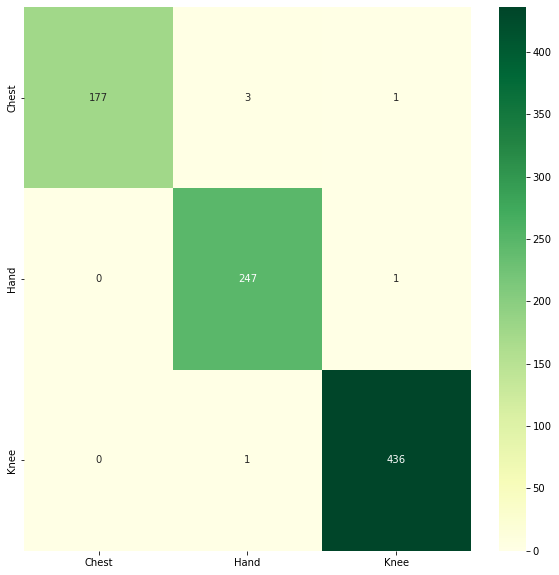

In [15]:
#Plotting Confusion Matrix.
cf_matrix = confusion_matrix(targetimagesdata_test_categorical1, predict_imagesdata_classes1)
plt.figure(figsize = (10,10))
classes = ['Chest','Hand','Knee']
group_counts = ['{0:0.0f}'.format(value) for value in
cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]

sns.heatmap(cf_matrix, annot=True, fmt='', cmap= "YlGn" ,
xticklabels = classes,yticklabels = classes)

In [16]:
#Storing actual class labels and predicted ones in a dataframe.
resultsA = pd.DataFrame({'Actual':targetimagesdata_test_categorical1,'Predicted':predict_imagesdata_classes1})

#Printing a few incorrectly classified images.
incorrect_dfA = resultsA[resultsA.Actual!=resultsA.Predicted]
incorrect_dfA.head()

,Actual,Predicted
77,1,2
193,2,1
266,0,1
346,0,1
438,0,2


### Discussion:
The CNN model (model1) performed very well in classifying the test images into their respective classes with a 99% accuracy and 99% precision. The model had a runtime of 2.04 minutes and a loss of 0.031. Of the 866 test images, 860 were correctly classified as seen in the confusion matrix.

# Experiment B

For the experiment, [keras image data generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) was used to generate augmented images to balance the dataset. This ensured that all classes used in training a model were equally weighted in terms of significance thus eliminating bias towards the larger class. The augmentation was done on the training data from Experiment A. The augmented images were saved to disk into a folder named 'Augmented' with three sub-folders for the three classes. These augmented images were then reloaded and used to train a CNN model which was used to classify the test dataset.

The augmented images dataset can be found [here](https://drive.google.com/drive/folders/1ft7-Fe06xKrbY-JoKPhQU2UB20i6YA6v?usp=sharing "Augmented Images").

### Image Augmentation

In [17]:
#Splitting the training dataset based on classes.
chest_images = imagesdata_train[np.where(targetimagesdata_train=='Chest')]
hand_images = imagesdata_train[np.where(targetimagesdata_train=='Hand')]
knee_images = imagesdata_train[np.where(targetimagesdata_train=='Knee')]

In [18]:
#Checking the shape of the split classes.
print(chest_images.shape)
print(hand_images.shape)
print(knee_images.shape)

(422, 100, 100)
(578, 100, 100)
(1019, 100, 100)


In [19]:
#Preprocessing the data for image augmentation.

#Reshaping into four dimensions.
chestimg_reshape = chest_images.reshape(chest_images.shape[0], 100, 100, 1)
handimg_reshape = hand_images.reshape(hand_images.shape[0], 100, 100, 1)
kneeimg_reshape = knee_images.reshape(knee_images.shape[0], 100, 100, 1)

#Converting to float 32.
chestimg_reshape = chestimg_reshape.astype('float32')
handimg_reshape = handimg_reshape.astype('float32')
kneeimg_reshape = kneeimg_reshape.astype('float32')

In [20]:
#Defining the image data generator.

datagen = ImageDataGenerator(rotation_range = 30, # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.2, # Randomly zoom image
                             width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                             horizontal_flip = True, # randomly flip images
                             fill_mode = 'nearest')

In [21]:
#Augmenting the images and saving them in appropriate folders.
start = timer()

i = 0
for batch in datagen.flow(chestimg_reshape,
                          batch_size = 1,
                          save_to_dir ='Augmented\Chest',
                          save_prefix = 'aug',
                          save_format = 'png'):
    i += 1
    if i > 1018:
        break

j = 0
for batch in datagen.flow(handimg_reshape,
                          batch_size = 1,
                          save_to_dir ='Augmented\Hand',
                          save_prefix = 'aug',
                          save_format = 'png'):
    j += 1
    if j > 1018:
        break

k = 0
for batch in datagen.flow(kneeimg_reshape,
                          batch_size = 1,
                          save_to_dir ='Augmented\Knee',
                          save_prefix = 'aug',
                          save_format = 'png'):
    k += 1
    if k > 1018:
        break        
        
end = timer()
print('Elapsed time:' + str(round(((end - start)/60), 2)) + ' mins')

Elapsed time:0.13 mins


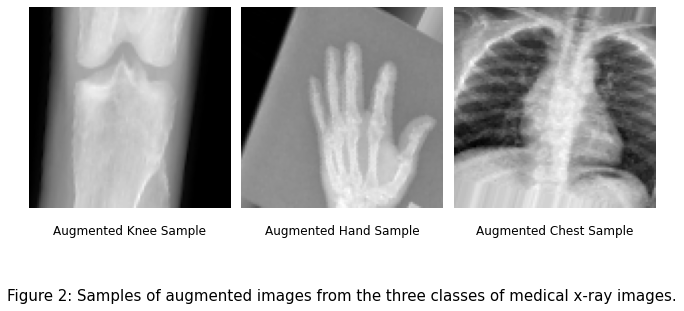

In [23]:
#Printing samples of the augmented images.

Augmented_Knee_Sample = cv.imread('Augmented/Knee/aug_0_6054.png')
Augmented_Hand_Sample = cv.imread('Augmented/Hand/aug_0_6761.png')
Augmented_Chest_Sample = cv.imread('Augmented/Chest/aug_0_769.png')

f, ax = plt.subplots(1, 3, figsize = (9,5))

ax[0].imshow(Augmented_Knee_Sample)
ax[1].imshow(Augmented_Hand_Sample)
ax[2].imshow(Augmented_Chest_Sample)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

ax[0].set_title('Augmented Knee Sample', y = -0.16)
ax[1].set_title('Augmented Hand Sample', y = -0.16)
ax[2].set_title('Augmented Chest Sample', y = -0.16)

title = 'Figure 2: Samples of augmented images from the three classes of medical x-ray images.'

plt.tight_layout()
f.suptitle(title, fontsize = 15, y = -0.004)
plt.show()

In [24]:
#Reloading Augmented Images for classification
start = timer()
path = 'Augmented'
AugImages = [] # List to append the augmented images as 2D numpy arrays.
AugTarget = [] # List to append the target

for root, dirs, files in os.walk(path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                augimg = cv.imread(root+'/'+file, 0) 
                AugImages.append(augimg)
                
                # Append the folder where the augmented image is to the target list
                AugTarget.append(root.replace(path,'').replace('\\','').replace('/',''))
            
            
            except Exception as e:
                print("Invalid file "+file+" skipped.")
                
#### SHOWING REPO BASED ON CLASS ####
auglabels = sorted(list(set(AugTarget)))
augvalues = []
for i in auglabels:
    augvalues.append(AugTarget.count(i))
    
##### CONVERTING THE REPO LIST INTO NUMPY ARRAY ##### 
AugImages = np.array(AugImages)

##################### PRINTING REPO SAMPLES ##########################
print('Sample of the Augmented Images repo:')
print(AugImages)
print('The shape of the Augmented Images repo is:' + str(AugImages.shape))
print('')

print('Sample of class labels: ')
print(np.array(AugTarget))
print('') 

end = timer()
print('Elapsed time:' + str(round(((end - start)/60), 2)) + ' mins')

Sample of the Augmented Images repo:
[[[180 182 159 ... 145 146 147]
  [172 187 174 ... 147 149 151]
  [165 182 181 ... 153 158 162]
  ...
  [148 154 157 ... 202 198 190]
  [157 158 157 ... 203 200 195]
  [156 153 152 ... 202 202 198]]

 [[ 74  74  73 ... 117 109 110]
  [ 91  87  84 ... 114 109 114]
  [ 78  82  85 ... 111 109 118]
  ...
  [186 195 193 ... 106 106 108]
  [188 195 192 ... 105 115 111]
  [191 194 192 ... 111 122 106]]

 [[132 134 133 ...  44  43  40]
  [149 137 132 ...  44  42  38]
  [144 157 150 ...  43  40  37]
  ...
  [219 227 229 ...  31  35  39]
  [224 229 226 ...  22  27  31]
  [227 229 224 ...  10  16  22]]

 ...

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[ 81  77  75 ...  91  91  92]
  [ 84  85  82 ...  90  92  93]
  [ 84  84  84 ...  91  92  97]
  ...
  [193 187 185 ...   0   0   0]
  [190 184 187 ...   0 


Calculating class distribution (after Image Augmentation)...
   Class  Number of Samples
0  Chest               1019
1   Hand               1019
2   Knee               1019
Total images: 3057

Showing class distribution bar chart (after Image Augmentation)...


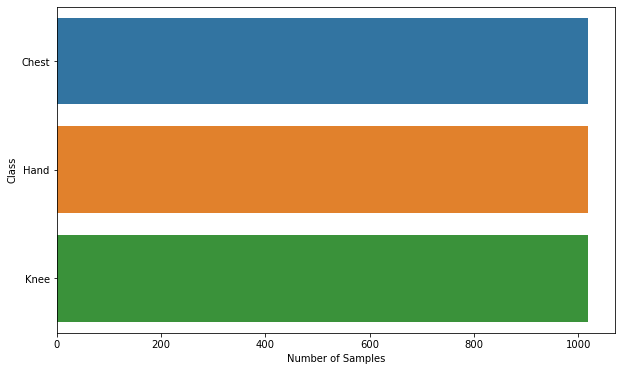

In [25]:
#CREATING FUNCTION FOR PRINTING AND PLOTTING BARPLOT TO SHOW CLASS DISTRIBUTION
print('\nCalculating class distribution (after Image Augmentation)...')
histo1 = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(AugTarget)))):
    cont = 0
    for j, label2 in enumerate(AugTarget):
        if label1 == label2:
            cont+=1
    histo1.append([label1,cont])
histo1.append(['Total Samples', len(AugTarget)])

#Converting histo1 into a panda dataframe
histo1_panda = pd.DataFrame.from_records(histo1[1:-1], columns=histo1[0])
print(histo1_panda)
print('Total images: '+str(len(AugTarget)))

#Creating a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo1_panda)

#Printing the image
sns_plot.figure.set_size_inches(10,6)
print('\nShowing class distribution bar chart (after Image Augmentation)...')
plt.show()

### Convolutional Neural Network

In [26]:
#Convverting the target labels of the augmented dataset into a numpy array.
AugTarget = np.array(AugTarget)

In [27]:
#Checking the shape of the data obtained as well as the test dataset.
print(AugImages.shape, AugTarget.shape, imagesdata_test_reshape.shape, targetimagesdata_test.shape)

(3057, 100, 100) (3057,) (866, 100, 100, 1) (866,)


In [28]:
#One-Hot-Encoding labels for use in CNN.
Augtargetnum1 = AugTarget.copy()
for index, items in enumerate(Augtargetnum1):
    if items == 'Chest':
        Augtargetnum1[index] = 0
    elif items == 'Hand':
        Augtargetnum1[index] = 1
    else :
        Augtargetnum1[index] = 2

In [29]:
###Preprocessing input data.

#Reshaping into four dimensions.
AugImages_reshape = AugImages.reshape(AugImages.shape[0], 100, 100, 1)

#Converting to float 32.
AugImages_reshape = AugImages_reshape.astype('float32')

#Normalising.
AugImages_reshape /= 255

#Preprocessing class labels.
AugTarget_categorical = np_utils.to_categorical(Augtargetnum1, 3)

In [30]:
start = timer()
os.environ['KERAS_BACKEND'] = 'tensorflow'

#Setting random seed for reproducibility.
np.random.seed(59)

#Defining the model architecture.
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

#compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model on training data
model2.fit(AugImages_reshape, AugTarget_categorical, batch_size=32, epochs=5, verbose=1)

end = timer()
print('Elapsed time:' + str(round(((end - start)/60), 2)) + ' mins')

Epoch 1/5
96/96 [==============================] - 37s 378ms/step - loss: 0.4948 - accuracy: 0.8171
Epoch 2/5
96/96 [==============================] - 40s 419ms/step - loss: 0.1653 - accuracy: 0.9444
Epoch 3/5
96/96 [==============================] - 36s 378ms/step - loss: 0.0868 - accuracy: 0.9728
Epoch 4/5
96/96 [==============================] - 38s 392ms/step - loss: 0.0598 - accuracy: 0.9804
Epoch 5/5
96/96 [==============================] - 39s 407ms/step - loss: 0.0583 - accuracy: 0.9794
Elapsed time:3.17 mins


In [31]:
#Viewing model summary.
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9437312   
                                                      

In [32]:
#Evaluating model on test data.
loss2, accuracy2 = model2.evaluate(imagesdata_test_reshape, targetimagesdata_test_categorical, verbose=0)
print('Loss: ', loss2, 'n\Acc: ', accuracy2)

Loss:  0.11145689338445663 n\Acc:  0.974595844745636


In [33]:
#Making predictions.
predict_imagesdata2=model2.predict(imagesdata_test_reshape)
predict_imagesdata_classes2= np.argmax(predict_imagesdata2,axis=1)
targetimagesdata_test_categorical2 = np.argmax(targetimagesdata_test_categorical,axis=1)

In [34]:
#Printing Classification Report.
print(classification_report(targetimagesdata_test_categorical2, predict_imagesdata_classes2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       181
           1       0.93      1.00      0.96       248
           2       1.00      0.96      0.98       437

    accuracy                           0.97       866
   macro avg       0.97      0.98      0.97       866
weighted avg       0.98      0.97      0.97       866



<AxesSubplot:>

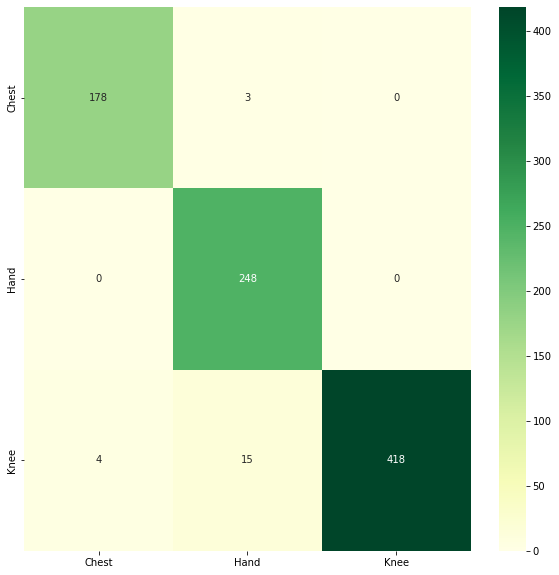

In [35]:
#Plotting Confusion Matrix.
cf_matrix2 = confusion_matrix(targetimagesdata_test_categorical2, predict_imagesdata_classes2)
plt.figure(figsize = (10,10))
classes = ['Chest','Hand','Knee']
group_counts = ['{0:0.0f}'.format(value) for value in
cf_matrix2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
cf_matrix2.flatten()/np.sum(cf_matrix)]

sns.heatmap(cf_matrix2, annot=True, fmt='', cmap= "YlGn" ,
xticklabels = classes,yticklabels = classes)

In [36]:
#Storing actual class labels and predicted ones in a dataframe.
resultsB = pd.DataFrame({'Actual':targetimagesdata_test_categorical2,'Predicted':predict_imagesdata_classes2})

#Printing a few incorrectly classified images.
incorrect_dfB = resultsB[resultsB.Actual != resultsB.Predicted]
incorrect_dfB.head()

,Actual,Predicted
46,2,1
142,2,1
172,2,0
189,2,1
193,2,1


### Discussion:
The CNN model that was trained using the augmented images (model2) also performed very well in classifying the test images but less better compared to model1. The model predicted the image classes with an accuracy of 97% and precision of 98%. The model had a runtime of 3.17 minutes and a loss of 0.111. Of the 866 test images, 844 were correctly classified with all hand images correctly classified as seen in the confusion matrix.

# Experiment C

Feature extraction using HOG was carried out at the beginning of this project and extracted features were saved in a repo called 'hogrepo'. For this experiment, the training dataset from the hogrepo was used to train a Support Vector Machine model. The one verse rest approach was applied to the SVM to model each class against the two other classes independently. The model was then used to classify the test dataset from the hogrepo.

### Support Vector Machine

In [37]:
#Applying Support Vector Classification.
svm_model = SVC(kernel='linear', C=0.01, decision_function_shape='ovr', random_state=42)

In [38]:
#Fitting the model.
np.random.seed(59)
clf_svm = svm_model.fit(hog_train,targethog_train)

In [39]:
#Evaluation of the model on the test set.
y_svm = svm_model.predict(hog_test)

In [40]:
#Calculating resulting metrics from evaluation.
print('Precision: ', precision_score(y_svm, targethog_test, average='weighted'))
print('Recall: ', recall_score(y_svm, targethog_test, average='weighted'))
print('F1-Score: ',f1_score(y_svm, targethog_test, average='weighted'))

Precision:  0.9954252060967342
Recall:  0.9953810623556582
F1-Score:  0.9953816310868816


Confusion matrix of hog repo:


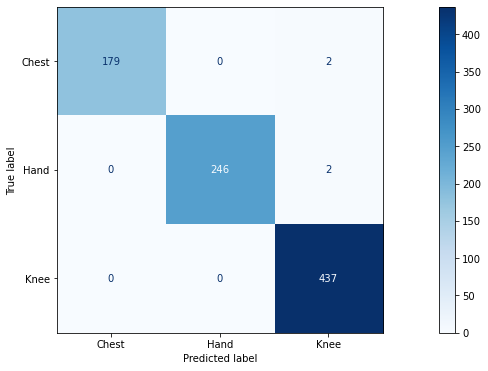

In [42]:
#Confusion matrix of classification.
print('Confusion matrix of hog repo:')
plot_confusion_matrix(clf_svm, hog_test, targethog_test, cmap=plt.cm.Blues)  
plt.rcParams["figure.figsize"] = (20, 6)
plt.show()  

### Discussion:
The SVM model (svm_model) performed very well in classifying the test images with a precision of 99.5%. 862 of the 866 test images were correctly predicted. All Knee images were correctly classified while two images each of the Chest and Hand classes were incorrectly predicted as Knee images.

# Experiment D

For this experiment, [Imbalanced learn's Random Oversampling](https://imbalanced-learn.org/stable/over_sampling.html) was applied on the training dataset of the hogrepo, creating a balanced repo called 'hogrepo_ros'. This repo was then used to train an SVM model. The one verse rest approach was also applied to the SVM. The model was then used to classify the test dataset from the hogrepo.

### Data Augmentation

In [43]:
#Balancing hogrepo training dataset using Random Oversampling.
ros = RandomOverSampler(random_state=0)
hog_ros, target_ros = ros.fit_resample(hog_train,targethog_train)


Calculating class distribution (after ROS)...
   Class  Number of Samples
0  Chest               1019
1   Hand               1019
2   Knee               1019
Total images: 3057

Showing class distribution bar chart (after ROS)...


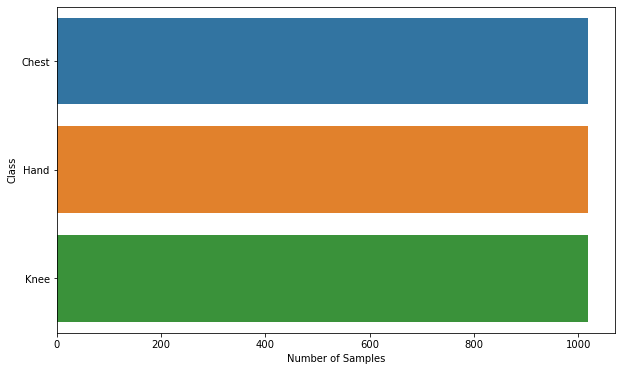

Size of ROS augmented hog target:  3057

Size of ROS augmented hog repository:  (3057, 1800)

Example of the ROS augmented hog repository: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.43459631 0.43459631 0.43459631]
 [0.32497065 0.04313256 0.06785194 ... 0.31255093 0.31255093 0.31255093]
 ...
 [0.33647547 0.20534034 0.01629629 ... 0.         0.         0.6298727 ]
 [0.49016568 0.17542584 0.09591656 ... 0.00483888 0.         0.        ]
 [0.51434989 0.         0.         ... 0.         0.         0.562134  ]]


In [44]:
############## DISTRIBUTION OF BALANCED HOGREPO ################

print('\nCalculating class distribution (after ROS)...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_ros)))):
    cont = 0
    for j, label2 in enumerate(target_ros):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_ros)])

## Save the histogram as a .csv file   
with open('classdistribution_ros.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)

## Convert histo into a panda dataframe
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target_ros)))

## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)

## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart_ros.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart (after ROS)...')
plt.show()

print('Size of ROS augmented hog target: ', len(target_ros))
print('') 
print('Size of ROS augmented hog repository: ', hog_ros.shape)
print('') 
print('Example of the ROS augmented hog repository: ')
print(hog_ros)

### Support Vector Machine

In [45]:
#Applying Support Vector Classification.
svm_model2 = SVC(kernel='linear', C=0.01, decision_function_shape='ovr', random_state=42)

In [46]:
#Fitting the model.
np.random.seed(59)
clf_svm2 = svm_model2.fit(hog_ros,target_ros)

In [47]:
#Evaluation of the model on the test set.
y_svm2 = svm_model2.predict(hog_test)

In [48]:
#Calculating resulting metrics from evaluation.
print('Precision: ', precision_score(y_svm2, targethog_test, average='weighted'))
print('Recall: ', recall_score(y_svm2, targethog_test, average='weighted'))
print('F1-Score: ',f1_score(y_svm2, targethog_test, average='weighted'))

Precision:  0.998849921776056
Recall:  0.9988452655889145
F1-Score:  0.9988457721390749


Normalized confusion matrix of randomly oversampled hog repo:


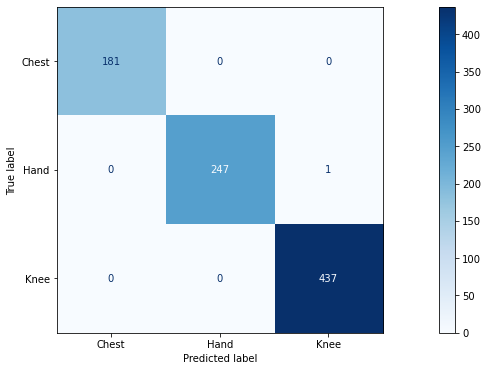

In [49]:
#Confusion matrix of classification.
print('Normalized confusion matrix of randomly oversampled hog repo:')
plot_confusion_matrix(clf_svm2, hog_test, targethog_test, cmap=plt.cm.Blues) 
plt.rcParams["figure.figsize"] = (20,6)
plt.show()  

### Discussion:
As expected, the SVM model that was trained using the augmented hogrepo training data (svm_model2) performed better in classifying the test images with 99.9% precision. Only one test image was incorrectly predicted. All Chest and Knee images were correctly classified as shown in the confusion matrix.

# Results and Conclusion

### Results
The performances of all four experiments were evaluated using precision, recall and F1-score metrics. A summary of the results is shown in the table below:

| Experiment | Precision | Recall | F1-Score | 
| --- | --- | --- | --- |
| A | 0.99 | 0.99 | 0.99 |
| B | 0.98 | 0.97 |0.97 |
| C | 0.995 | 0.995 | 0.995 |
| D | 0.999 | 0.999 | 0.999 |

All four models performed very well in predicting the classes of the test data. CNNs were used for experiments A and B. Experiment A performed better than experiment B even though the model for B was trained using a balanced dataset. It is possible that the learning algorithm found it a little harder to classify the test images after learning from the augmented images. Experiment A also had a better runtime than experiment B.

Experiments C and D were carried out on HOG extracted features using SVM. The model for Experiment D was trained using a balanced dataset and, as expected, it outperformed that of Experiment C even if by a little margin. 

### Conclusion and future research recommendation
CNN and SVM models were implemented to classify medical x-ray images into three classes; Chest, Hand and Knee. A stratified split was applied on the datasets. Models were designed and applied to a set of repos created using the unaltered image dataset, Keras image data generator, HOG and ROS. At the end of the experiments, based on metrics, SVM applied on the augmented HOG repo (hog_ros) performed best. The augmented repo was more accurate than the unbalanced repo for the SVM but not in the CNN.

Given that a variety of combinations of hyperparameters are possible, future research can take advantage of hyperparameter tuning to determine the best combination suitable for the models to achieve optimum result.

# References

BUDNYCHUK, A., 2021. *Hand X-ray*. [Online]. Kaggle. Available from: https://www.kaggle.com/antonbudnychuk/hand-xray [Accessed 6 February 2022].

GORNALE, S. & PATRAVALI, P., 2020. *Digital Knee X-ray Images*. [Online]. Mendeley Data. Available from: https://data.mendeley.com/datasets/t9ndx37v5h/1 [Accessed 4 February 2022].

SHAMS, M., ELZEKI, O. & ABD ELFATTAH, M., 2020. *Chest X-ray images with three classes: COVID-19, Normal, and Pneumonia*. [Online]. Mendeley Data. Available from: https://data.mendeley.com/datasets/fvk7h5dg2p/1 [Accessed 6 February 2022].

TENSORFLOW, 2022. *tf.keras.preprocessing.image.ImageDataGenerator*. [Online]. TensorFlow. Available from: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator [Accessed 4 April 2022].

THE IMBALANCED-LEARN DEVELOPERS, 2022. *2. Over-sampling*. [Online]. Available from: https://imbalanced-learn.org/stable/over_sampling.html [Accessed 25 March 2022].